In [3]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
from ngsolve import *
from ngsolve import Mesh
from ngsolve import x, y, z
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square
from netgen.occ import *

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# ---------- Parameters ----------
L, W, H      = 3.0, 1.0, 1.0
baffle_thk   = 0.05
baffle_len   = 0.70*W
baffle_x     = [0.7, 1.5, 2.3]   # positions of the three baffles
half_model   = False
maxh         = 0.1  # mesh size

# stub parameters
Lin_ext  = 0.4   # inlet stub length
Lout_ext = 0.4   # outlet stub length
stub_frac = 0.5  # fraction of duct cross-section used for stub

# ---------- Main duct ----------
duct = Box(Pnt(0,0,0), Pnt(L, W, H))
duct.faces.name = "walls"

# ---------- Baffles ----------
fluid = duct
for i, x0 in enumerate(baffle_x, 1):
    x0min = x0 - 0.5*baffle_thk
    x0max = x0 + 0.5*baffle_thk
    zmin, zmax = 0, H

    if i == 2:  # middle baffle from TOP wall
        ymin, ymax = W - baffle_len, W
    else:       # side baffles from BOTTOM wall
        ymin, ymax = 0, baffle_len

    plate = Box(Pnt(x0min, ymin, zmin), Pnt(x0max, ymax, zmax))
    plate.faces.name = f"baffle{i}"
    fluid = fluid - plate

# ---------- Inlet stub ----------
stub_ymin = (1-stub_frac)/2 * W
stub_ymax = (1+stub_frac)/2 * W
stub_zmin = (1-stub_frac)/2 * H
stub_zmax = (1+stub_frac)/2 * H

stub_in = Box(Pnt(-Lin_ext, stub_ymin, stub_zmin),
              Pnt(0,        stub_ymax, stub_zmax))
stub_in.faces.name = "walls"           # stub sides are walls
stub_in.faces.Min(X).name = "inlet"    # only far end is inlet

# ---------- Outlet stub ----------
stub_out = Box(Pnt(L, stub_ymin, stub_zmin),
               Pnt(L+Lout_ext, stub_ymax, stub_zmax))
stub_out.faces.name = "walls"          # stub sides are walls
stub_out.faces.Max(X).name = "outlet"  # only far end is outlet

# ---------- Combine duct + stubs ----------
fluid = fluid + stub_in + stub_out

# ---------- Apply half-model cut if desired ----------
if half_model:
    sym_half = HalfSpace(Pnt(0, W/2, 0), Vec(0,1,0))
    fluid = fluid * sym_half

# ---------- Build OCC geometry and mesh ----------
geo = OCCGeometry(fluid)
m = geo.GenerateMesh(maxh=maxh)
mesh = Mesh(m)

print("Mesh elements:", mesh.ne)
print("Boundary names:", mesh.GetBoundaries())

# ---------- Count boundary elements ----------
counter = Counter()
for el in mesh.Elements(BND):
    counter[el.mat] += 1
print("Boundary facet counts:", counter)

# ---------- Visualize boundaries ----------
cf = mesh.BoundaryCF({
    "inlet":   10,
    "outlet":  20,
    "walls":   30,
    "baffle1": 40,
    "baffle2": 50,
    "baffle3": 60
}, default=0)

Draw(mesh)

Mesh elements: 16210
Boundary names: ('walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'baffle1', 'baffle2', 'baffle2', 'baffle2', 'walls', 'walls', 'walls', 'baffle3', 'baffle3', 'baffle3', 'walls', 'baffle1', 'baffle1', 'inlet', 'walls', 'walls', 'walls', 'walls', 'outlet')
Boundary facet counts: Counter({'walls': 3324, 'baffle2': 374, 'baffle1': 336, 'baffle3': 318, 'inlet': 56, 'outlet': 50})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [ ]:


SetNumThreads(1)

# ------------ parameters ------------
nu_f      = 0.01          # viscosity
U0        = 1.0           # target peak inlet speed
omega0    = 0.3           # under-relaxation
tol       = 1e-4          # Picard stopping criterion
maxit     = 50            # allow more iterations if needed
gamma_gd  = 0.7           # grad-div penalty
use_backflow = True

# ------------ FE spaces ------------
V = VectorH1(mesh, order=1, dirichlet="walls|baffle1|baffle2|baffle3|inlet")
Q = H1(mesh, order=1)
fes = V*Q
(u, p), (v, q) = fes.TnT()

# inlet profile helper
def inlet_cf(U0):
    prof = U0 * (1 - (2*y/W-1)**2) * (1 - (2*z/H-1)**2)
    return CoefficientFunction((prof, 0, 0))

# lifting (velocity only)
def lifting(U0):
    g = GridFunction(fes)
    g.components[0].Set(inlet_cf(U0), BND, definedon=mesh.Boundaries("inlet"))
    return g

# ------------ Stokes warm-start ------------
gS = lifting(U0)  # directly use full U0

aS = BilinearForm(fes, symmetric=True)
aS += nu_f * InnerProduct(Grad(u), Grad(v)) * dx
aS += (-div(v)*p - q*div(u)) * dx
aS += 1e-12*p*q*dx
aS += gamma_gd * div(u)*div(v) * dx

fS = LinearForm(fes)
aS.Assemble(); fS.Assemble()
rhs = fS.vec.CreateVector(); rhs.data = fS.vec - aS.mat*gS.vec
sol = GridFunction(fes)
inv = aS.mat.Inverse(fes.FreeDofs(), inverse="pardiso")
sol.vec.data = gS.vec + inv*rhs

u_vel = GridFunction(V); u_vel.vec.data = sol.components[0].vec
p_prs = GridFunction(Q); p_prs.vec.data = sol.components[1].vec
print("Stokes L2(u) =", float(Integrate(Norm(u_vel), mesh)))

# ------------ Oseen iteration (direct to U0) ------------
n = specialcf.normal(3)
g = lifting(U0)
uk = GridFunction(V); uk.vec.data = u_vel.vec
omega = omega0
last_rel = None

for it in range(1, maxit+1):
    aO = BilinearForm(fes, symmetric=False)
    aO += nu_f * InnerProduct(Grad(u), Grad(v)) * dx
    aO += InnerProduct(Grad(u)*uk, v) * dx
    aO += (-div(v)*p - q*div(u)) * dx
    aO += 1e-12*p*q*dx
    aO += gamma_gd * div(u)*div(v) * dx

    if use_backflow:
        un = InnerProduct(uk, n)
        neg_un = IfPos(-un, -un, 0.0)   # penalize only backflow
        aO += 0.5*neg_un*InnerProduct(u, v) * ds(definedon=mesh.Boundaries("outlet"))

    fO = LinearForm(fes)
    aO.Assemble(); fO.Assemble()
    rhs = fO.vec.CreateVector(); rhs.data = fO.vec - aO.mat*g.vec
    sol = GridFunction(fes)
    inv = aO.mat.Inverse(fes.FreeDofs(), inverse="pardiso")
    sol.vec.data = g.vec + inv*rhs

    du  = GridFunction(V); du.vec.data = sol.components[0].vec - u_vel.vec
    rel = Norm(du.vec) / max(Norm(sol.components[0].vec), 1e-30)
    print(f"  iter {it:2d}: rel = {rel:.3e}, omega={omega:.2f}")

    # under-relaxed update
    u_vel.vec.data = (1-omega)*u_vel.vec + omega*sol.components[0].vec
    p_prs.vec.data = (1-omega)*p_prs.vec + omega*sol.components[1].vec
    uk.vec.data    = u_vel.vec

    if rel < tol:
        print("  converged.")
        break

    if last_rel is not None and rel > 1.25*last_rel and omega > 0.18:
        omega *= 0.7
    last_rel = rel

# ------------ Rescale velocity to U0 ------------
inlet_area = Integrate(1, mesh, BND, definedon=mesh.Boundaries("inlet"))
avg_inlet  = Integrate(Norm(u_vel), mesh, BND, definedon=mesh.Boundaries("inlet")) / inlet_area
scale = U0 / avg_inlet
print(f"\nScaling velocity field by factor {scale}")
u_vel.vec.data *= scale

avg_inlet_new = Integrate(Norm(u_vel), mesh, BND, definedon=mesh.Boundaries("inlet")) / inlet_area
print("new avg |u| on inlet =", avg_inlet_new)

# convection field for scalar problem
b = CoefficientFunction((u_vel[0], u_vel[1], u_vel[2]))
VTKOutput(ma=mesh, coefs=[u_vel], names=["u"], filename="solution_navier1", subdivision=2).Do()


Stokes L2(u) = 1.2110488780460822
  iter  1: rel = 2.730e-01, omega=0.30
  iter  2: rel = 2.068e-01, omega=0.30
  iter  3: rel = 1.566e-01, omega=0.30
  iter  4: rel = 1.188e-01, omega=0.30
  iter  5: rel = 9.061e-02, omega=0.30
  iter  6: rel = 6.961e-02, omega=0.30
  iter  7: rel = 5.383e-02, omega=0.30
  iter  8: rel = 4.183e-02, omega=0.30
  iter  9: rel = 3.257e-02, omega=0.30
  iter 10: rel = 2.536e-02, omega=0.30
  iter 11: rel = 1.973e-02, omega=0.30
  iter 12: rel = 1.535e-02, omega=0.30
  iter 13: rel = 1.198e-02, omega=0.30
  iter 14: rel = 9.397e-03, omega=0.30
  iter 15: rel = 7.441e-03, omega=0.30
  iter 16: rel = 5.956e-03, omega=0.30
  iter 17: rel = 4.819e-03, omega=0.30
  iter 18: rel = 3.930e-03, omega=0.30
  iter 19: rel = 3.219e-03, omega=0.30
  iter 20: rel = 2.636e-03, omega=0.30
  iter 21: rel = 2.150e-03, omega=0.30
  iter 22: rel = 1.743e-03, omega=0.30
  iter 23: rel = 1.401e-03, omega=0.30
  iter 24: rel = 1.116e-03, omega=0.30
  iter 25: rel = 8.805e-04, om

'solution_navier'

In [8]:
# ------------------------------
# 1) Full-order model setup
# ------------------------------
supg_C=1.0
# FE space (scalar H1)
V = H1(mesh, order=1, dirichlet="walls|inlet|baffle1|baffle2|baffle3")
u, v = V.TnT()
proto = GridFunction(V).vec

# convection field b from NS velocity
b = CoefficientFunction((u_vel[0], u_vel[1], u_vel[2]))
bnorm = Norm(b) + 1e-12
hK  = specialcf.mesh_size
tau = supg_C * hK / bnorm                # simple, effective τ ~ h/|b|

# helper: boundary-lifting GridFunction g from {name: value/None}
def make_lifting(bc_vals: dict) -> GridFunction:
    """Create GridFunction g with boundary values; use None for Neumann parts."""
    g = GridFunction(V)
    names = list(mesh.GetBoundaries())
    vals  = [0.0 if bc_vals.get(nm, None) is None else float(bc_vals[nm]) for nm in names]
    g.Set(CoefficientFunction(vals), BND)
    return g



# Full-order solve
def solve_fom(g1, g2, g3, Pe) -> GridFunction:
    a = BilinearForm(V, symmetric=False)
    a += 1/Pe*InnerProduct(grad(u), grad(v)) * dx
    a += InnerProduct(b, grad(u)) * v * dx

    a += tau * (InnerProduct(b,grad(u))) * (InnerProduct(b,grad(v))) * dx
    a.Assemble()
    f = LinearForm(V)
    f.Assemble()

    bc_vals = {"walls":0.0, "inlet":0.0, "baffle1":g1, "baffle2":g2, "baffle3":g3, "outlet":None}
    g = make_lifting(bc_vals)
    rhs = f.vec.CreateVector()
    rhs.data = f.vec - a.mat * g.vec
    uN  = GridFunction(V)
    uN.vec.data = g.vec + a.mat.Inverse(V.FreeDofs()) * rhs
    return uN
# A_times: apply A to a NumPy vector of size N. "Sparse multiply"
def A_times(vec_np: np.ndarray,A) -> np.ndarray:
    x = proto.CreateVector(); y = proto.CreateVector()
    if len(vec_np) != len(x.FV().NumPy()):
        raise ValueError(f"Dimension mismatch: got {len(vec_np)} vs FE dim {len(x.FV().NumPy())}")
    x.FV().NumPy()[:] = vec_np
    y.data = A.mat * x
    return y.FV().NumPy()


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

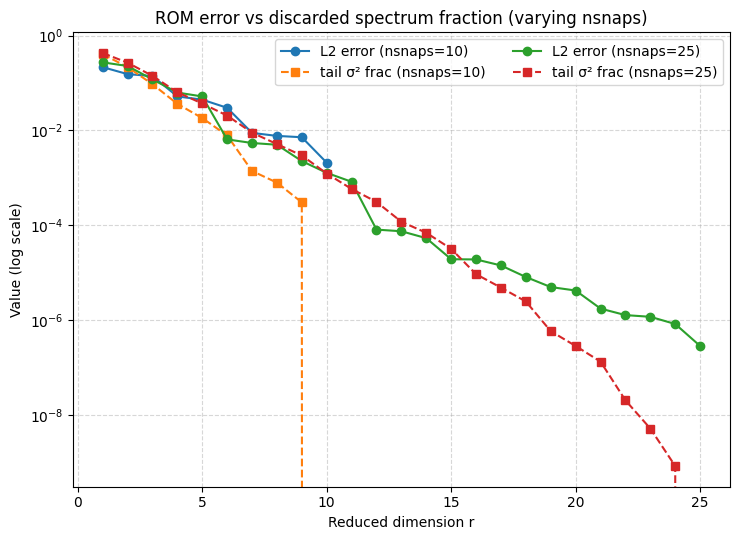

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 0) One-time operator assembly (uses your V, u, v, b, tau)
# -------------------------------------------------
def A_times(vec_np, Aform):
    """Apply assembled bilinear form Aform to a NumPy vector (size N) and return NumPy result."""
    x = proto.CreateVector(); y = proto.CreateVector()
    x.FV().NumPy()[:] = vec_np
    y.data = Aform.mat * x
    return y.FV().NumPy()

A_diff = BilinearForm(V, symmetric=False)
A_diff += InnerProduct(grad(u), grad(v)) * dx
A_diff.Assemble()

A_adv = BilinearForm(V, symmetric=False)
A_adv += InnerProduct(b, grad(u)) * v * dx
A_adv += tau * (InnerProduct(b, grad(u))) * (InnerProduct(b, grad(v))) * dx
A_adv.Assemble()

f = LinearForm(V)
f.Assemble()

# -------------------------------------------------
# 1) One experiment for a given nsnaps
# -------------------------------------------------
def run_rom_experiment(nsnaps, test_params=(6, 9, 12), Pe_test=100, pod_tol=1e-12, seed=None):
    """
    Build a POD-ROM from 'nsnaps' random snapshots and evaluate error vs r.
    Returns (rs, errors, tails, rmax).
    """
    rng = np.random.default_rng(seed)

    # --- draw random parameter snapshots (g1,g2,g3,Pe) ---
    g1 = rng.uniform(0.0, 12.0, nsnaps)
    g2 = rng.uniform(0.0, 12.0, nsnaps)
    g3 = rng.uniform(0.0, 12.0, nsnaps)
    Pe = rng.uniform(1.0, 600.0, nsnaps)

    snaps = []
    for j in range(nsnaps):
        u_full = solve_fom(float(g1[j]), float(g2[j]), float(g3[j]), Pe=float(Pe[j]))
        g = make_lifting({"walls":0.0, "inlet":0.0,
                          "baffle1":float(g1[j]), "baffle2":float(g2[j]), "baffle3":float(g3[j]),
                          "outlet":None})
        w_np = u_full.vec.FV().NumPy() - g.vec.FV().NumPy()
        snaps.append(w_np.copy())

    # --- POD basis ---
    N = len(snaps[0])
    space   = NumpyVectorSpace(N)
    snap_va = space.make_array(np.vstack(snaps))
    RB, svals_trunc = pod(snap_va, rtol=pod_tol, modes=None, l2_err=False)
    rmax = len(RB)
    Vr = np.column_stack([RB[i].to_numpy().ravel() for i in range(rmax)])   # N x rmax

    # --- full singular values (for POD energy tail) ---
    snap_mat = np.vstack(snaps)                    # (nsnaps, N)
    svals_full = np.linalg.svd(snap_mat, compute_uv=False)
    total_energy = float(np.sum(svals_full**2))

    # --- precompute A*Vr blocks (independent of Pe online) ---
    A_V_diff  = np.column_stack([A_times(Vr[:, j], A_diff) for j in range(rmax)])  # N x rmax
    A_V_adv   = np.column_stack([A_times(Vr[:, j], A_adv)  for j in range(rmax)])  # N x rmax

    # --- inner reduced solve with slicing ---
    def solve_reduced_slice(g1v, g2v, g3v, Pev, ruse):
        Vr_r       = Vr[:, :ruse]
        A_V_diff_r = A_V_diff[:, :ruse]
        A_V_adv_r  = A_V_adv[:, :ruse]
        fr         = Vr_r.T @ f.vec.FV().NumPy()

        g = make_lifting({"walls":0.0, "inlet":0.0,
                          "baffle1":g1v, "baffle2":g2v, "baffle3":g3v,
                          "outlet":None})
        g_np = g.vec.FV().NumPy()

        Ar   = Vr_r.T @ ((1.0/Pev)*A_V_diff_r + A_V_adv_r)
        AgNP = (1.0/Pev)*A_times(g_np, A_diff) + A_times(g_np, A_adv)
        RHS  = fr - Vr_r.T @ AgNP

        w_r  = np.linalg.solve(Ar, RHS)
        u_np = g_np + Vr_r @ w_r
        u = GridFunction(V); u.vec.FV().NumPy()[:] = u_np
        return u

    # --- reference FOM for error evaluation ---
    u_fom = solve_fom(*test_params, Pe=Pe_test)

    # --- sweep r and collect errors + tail fractions ---
    rs     = range(1, rmax+1)
    errors = []
    tails  = []
    for rtest in rs:
        u_rom = solve_reduced_slice(*test_params, Pe_test, rtest)
        diff = GridFunction(V); diff.vec[:] = u_fom.vec.FV().NumPy() - u_rom.vec.FV().NumPy()
        relL2 = np.sqrt( Integrate(diff*diff, mesh) / Integrate(u_fom*u_fom, mesh) )
        errors.append(float(relL2))

        # POD theory uses σ^2 (energy)
        # tail_frac = float(np.sum(svals_full[rtest:]**2) / (total_energy + 1e-30))
        tail_frac = np.sum(svals_full[rtest:])/np.sum(svals_full)
        tails.append(tail_frac)

    return rs, np.array(errors), np.array(tails), rmax

# -------------------------------------------------
# 2) Run for multiple training sizes and plot
# -------------------------------------------------
training_sizes = [10,25]
plt.figure(figsize=(7.5,5.5))

for ns in training_sizes:
    rs, errors, tails, rmax = run_rom_experiment(
        nsnaps=ns, test_params=(6,9,12), Pe_test=100, pod_tol=1e-12, seed=42
    )
    plt.semilogy(rs, errors, 'o-', label=f'L2 error (nsnaps={ns})')
    plt.semilogy(rs, tails,  's--', label=f'tail σ² frac (nsnaps={ns})')

plt.xlabel("Reduced dimension r")
plt.ylabel("Value (log scale)")
plt.title("ROM error vs discarded spectrum fraction (varying nsnaps)")
plt.legend(ncol=2)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

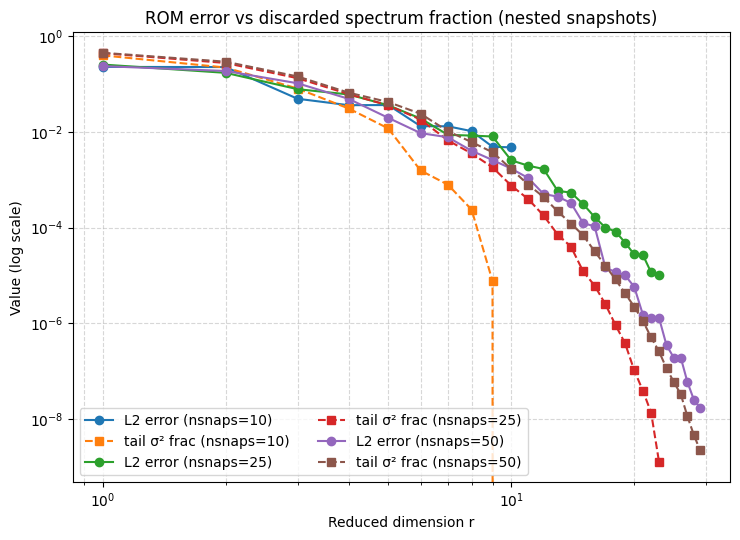

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 0) Assemble global operators (once)
# -------------------------------------------------
def A_times(vec_np, Aform):
    x = proto.CreateVector(); y = proto.CreateVector()
    x.FV().NumPy()[:] = vec_np
    y.data = Aform.mat * x
    return y.FV().NumPy()

A_diff = BilinearForm(V, symmetric=False)
A_diff += InnerProduct(grad(u), grad(v)) * dx
A_diff.Assemble()

A_adv = BilinearForm(V, symmetric=False)
A_adv += InnerProduct(b, grad(u)) * v * dx
A_adv += tau * (InnerProduct(b, grad(u))) * (InnerProduct(b,grad(v))) * dx
A_adv.Assemble()

f = LinearForm(V)
f.Assemble()

# -------------------------------------------------
# 1) Generate one large snapshot pool (FOM solutions)
# -------------------------------------------------
def generate_snapshot_pool(nsnaps_max, seed=None):
    rng = np.random.default_rng(seed)
    g1 = rng.uniform(0.0, 12.0, nsnaps_max)
    g2 = rng.uniform(0.0, 12.0, nsnaps_max)
    g3 = rng.uniform(0.0, 12.0, nsnaps_max)
    Pe = rng.uniform(1.0, 600.0, nsnaps_max)

    snaps = []
    for j in range(nsnaps_max):
        u_full = solve_fom(float(g1[j]), float(g2[j]), float(g3[j]), Pe=float(Pe[j]))
        g = make_lifting({"walls":0.0, "inlet":0.0,
                          "baffle1":float(g1[j]), "baffle2":float(g2[j]), "baffle3":float(g3[j]),
                          "outlet":None})
        w_np = u_full.vec.FV().NumPy() - g.vec.FV().NumPy()
        snaps.append(w_np.copy())

    return np.vstack(snaps)   # shape (nsnaps_max, N)

# -------------------------------------------------
# 2) Run ROM experiment using first nsnaps from the pool
# -------------------------------------------------
def run_rom_experiment_from_pool(snap_pool, nsnaps, test_params=(6,9,12), Pe_test=100, pod_tol=1e-12):
    snaps = snap_pool[:nsnaps, :]    # take the first nsnaps

    # POD basis
    N = snaps.shape[1]
    space   = NumpyVectorSpace(N)
    snap_va = space.make_array(snaps)
    RB, _   = pod(snap_va, rtol=pod_tol, modes=None, l2_err=False)
    rmax = len(RB)
    Vr   = np.column_stack([RB[i].to_numpy().ravel() for i in range(rmax)])

    # singular values (full SVD for tail energy)
    svals_full = np.linalg.svd(snaps, compute_uv=False)
    total_energy = float(np.sum(svals_full**2))

    # precompute A*Vr
    A_V_diff = np.column_stack([A_times(Vr[:, j], A_diff) for j in range(rmax)])
    A_V_adv  = np.column_stack([A_times(Vr[:, j], A_adv)  for j in range(rmax)])

    # reduced solve (slice in r)
    def solve_reduced_slice(g1v, g2v, g3v, Pev, ruse):
        Vr_r       = Vr[:, :ruse]
        A_V_diff_r = A_V_diff[:, :ruse]
        A_V_adv_r  = A_V_adv[:, :ruse]
        fr         = Vr_r.T @ f.vec.FV().NumPy()

        g = make_lifting({"walls":0.0, "inlet":0.0,
                          "baffle1":g1v, "baffle2":g2v, "baffle3":g3v,
                          "outlet":None})
        g_np = g.vec.FV().NumPy()

        Ar   = Vr_r.T @ ((1.0/Pev)*A_V_diff_r + A_V_adv_r)
        AgNP = (1.0/Pev)*A_times(g_np, A_diff) + A_times(g_np, A_adv)
        RHS  = fr - Vr_r.T @ AgNP

        w_r  = np.linalg.solve(Ar, RHS)
        u_np = g_np + Vr_r @ w_r
        u = GridFunction(V); u.vec.FV().NumPy()[:] = u_np
        return u

    # reference FOM
    u_fom = solve_fom(*test_params, Pe=Pe_test)

    # sweep r
    rs, errors, tails = [], [], []
    for rtest in range(1, rmax+1):
        u_rom = solve_reduced_slice(*test_params, Pe_test, rtest)
        diff = GridFunction(V); diff.vec[:] = u_fom.vec.FV().NumPy() - u_rom.vec.FV().NumPy()
        relL2 = np.sqrt(Integrate(diff*diff, mesh) / Integrate(u_fom*u_fom, mesh))
        rs.append(rtest)
        errors.append(float(relL2))
        # tails.append(np.sum(svals_full[rtest:]**2)/(total_energy+1e-30))
        tails.append(np.sum(svals_full[rtest:])/(np.sum(svals_full)))

    return rs, np.array(errors), np.array(tails), rmax

# -------------------------------------------------
# 3) Main driver: generate once, reuse pool
# -------------------------------------------------
training_sizes = [10, 25,50]
nsnaps_max = max(training_sizes)

snap_pool = generate_snapshot_pool(nsnaps_max, seed=42)

plt.figure(figsize=(7.5,5.5))

for ns in training_sizes:
    rs, errors, tails, rmax = run_rom_experiment_from_pool(snap_pool, ns, test_params=(6,9,12), Pe_test=100)
    # plt.semilogy(rs, errors, 'o-', label=f'L2 error (nsnaps={ns})')
    # plt.semilogy(rs, tails,  's--', label=f'tail σ² frac (nsnaps={ns})')
    plt.loglog(rs, errors, 'o-', label=f'L2 error (nsnaps={ns})')
    plt.loglog(rs, tails,  's--', label=f'tail σ² frac (nsnaps={ns})')
plt.xlabel("Reduced dimension r")
plt.ylabel("Value (log scale)")
plt.title("ROM error vs discarded spectrum fraction (nested snapshots)")
plt.legend(ncol=2)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()
